In [12]:
import pandas as pd
from  sklearn import tree
import sklearn.model_selection as skl_ms
import graphviz
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

array([[<AxesSubplot:xlabel='Number words female', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Total words', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Number of words lead', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Difference in words lead and co-lead', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Number of male actors', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Year', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Number of female actors', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Number words male', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Gross', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Mean Age Male', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Mean Age Female', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Age Lead', ylabel='Number words female'>,
        <AxesSubplot:xlabel='Age Co-Lead', ylabel='N

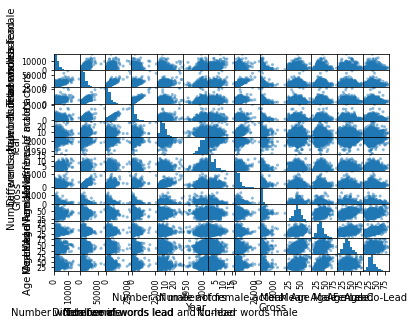

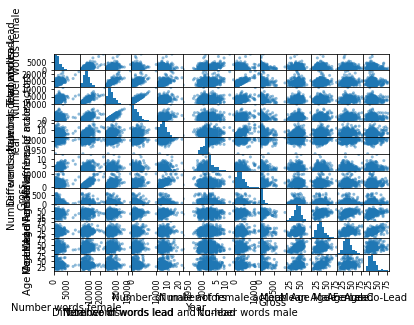

In [13]:
filmtalkTrain = pd.read_csv(r'train.csv')
filmtalkTest = pd.read_csv(r'test.csv')
pd.plotting.scatter_matrix(filmtalkTrain)
pd.plotting.scatter_matrix(filmtalkTest)

In [14]:
from sklearn.model_selection import train_test_split
X = filmtalkTrain.drop(['Lead'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [6]:
female = sum(y=='Female')
male = sum(y=='Male')
print(female, male)

254 785


array([[ 23,  20],
       [  7, 106]], dtype=int64)

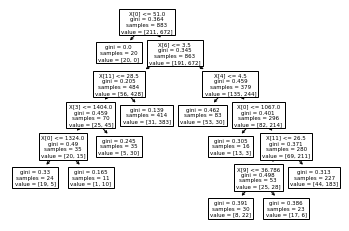

In [7]:
model = tree.DecisionTreeClassifier(max_leaf_nodes=20)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
dot_data = tree.export_graphviz(model, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("film")
dot_data  = tree.export_graphviz(model, out_file=None,  
                                filled=True, rounded=True,
                                special_characters=True)
graph  = graphviz.Source(dot_data)
graph.render('film')
prediction = model.predict(X_val)
#misclassification = np.mean(prediction!=y_val)
#print("the validation error is ",  misclassification)
# confusion matrix
confusion_matrix(y_val, prediction)
# female accuracy not good

[0.2692307692307692, 0.2692307692307692, 0.21153846153846154, 0.1987179487179487, 0.1987179487179487, 0.1987179487179487, 0.19230769230769232, 0.1858974358974359, 0.17307692307692307, 0.1987179487179487, 0.17307692307692307, 0.17307692307692307, 0.17307692307692307, 0.17307692307692307, 0.17307692307692307, 0.1794871794871795, 0.17307692307692307, 0.17307692307692307, 0.15384615384615385, 0.14102564102564102, 0.15384615384615385, 0.16025641025641027, 0.16666666666666666, 0.14743589743589744, 0.16025641025641027, 0.15384615384615385, 0.14743589743589744, 0.14743589743589744, 0.14743589743589744, 0.16025641025641027, 0.16025641025641027, 0.16025641025641027, 0.16025641025641027, 0.14743589743589744, 0.14743589743589744, 0.16025641025641027, 0.16025641025641027, 0.14743589743589744, 0.15384615384615385, 0.15384615384615385, 0.16666666666666666, 0.15384615384615385, 0.15384615384615385, 0.16666666666666666, 0.14743589743589744, 0.16666666666666666, 0.14102564102564102, 0.14102564102564102]

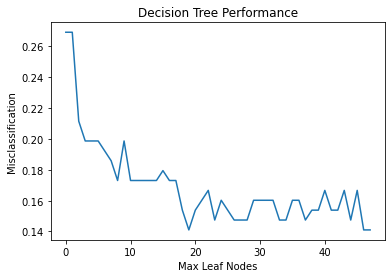

In [5]:
models =  []
misclassifications = []
for Number_of_leaf_nodes  in range(2, 50):
    model = tree.DecisionTreeClassifier(max_leaf_nodes=Number_of_leaf_nodes)
    model = model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    models.append(model)
    misclassification  = np.mean(prediction!=y_val)
    misclassifications.append(misclassification)

print(misclassifications)
plt.plot(misclassifications)
plt.xlabel('Max Leaf Nodes')
plt.ylabel('Misclassification')
plt.title('Decision Tree Performance')
plt.savefig('MaxLeafNodesTuning.png')
#Decide to take max_leaf_nodes  = 20

## Cross Validation:  k-fold cross validation 

In [15]:
n_fold  =  5

cv =  skl_ms.KFold(n_splits=n_fold, random_state=2, shuffle=True)
#K = np.arange(1, 11)
#misclassification = np.zeros(len(K))
misclassification =  np.zeros(n_fold)
modelDS = []
model = tree.DecisionTreeClassifier(max_leaf_nodes=20)
for i, (train_index, val_index) in enumerate(cv.split(X)):
    #print("Train:", train_index, "Val", val_index)
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = model.fit(X_train,  y_train)
    modelDS.append(model)
    prediction = model.predict(X_val)
    misclassification[i] = np.mean(prediction!=y_val)

index = np.argmin(misclassification)
OptimalModel = modelDS[index]
#misclassification /= n_fold
#plt.plot(misclassification)
print(1 - misclassification)
print(f"The optimal model is {index+1}th model")
print(f"The average accuracy is {1-np.mean(misclassification)}")

[0.76923077 0.80769231 0.75961538 0.83653846 0.84057971]
The optimal model is 5th model
The average accuracy is 0.8027313266443701


## Decision Tree with Adaboost

In [108]:
# Brute-force to find the optimal parameter
models  =  []
misclassifications  = np.ones((15, 10))
i = 0
j  = 0
for num_max_leaf_nodes in range(15, 30):
    for num_estimators in range(100, 1001, 100):
        DTBoosting = AdaBoostClassifier(
        DecisionTreeClassifier(max_leaf_nodes=num_max_leaf_nodes), n_estimators=num_estimators,algorithm="SAMME")
        X = filmtalkTrain.drop(['Lead'], axis = 'columns')
        y = filmtalkTrain['Lead']
        X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
        DTBoosting.fit(X_train, y_train)
        prediction = DTBoosting.predict(X_val)
        misclassification = np.mean(prediction!=y_val)
        misclassifications[i][j] = misclassification
        models.append(model)
        j +=1
    j = 0
    i+=1
print(misclassifications)
#plt.axes(projection = '3d')
#plt.plot(misclassifications)
#plt.xlabel('Max Leaf Nodes')
#plt.ylabel('Misclassification')
#plt.title('Decision Tree')

C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\

C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\

C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\

C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\

[[0.10897436 0.10897436 0.10897436 0.11538462 0.12179487 0.12179487
  0.13461538 0.09615385 0.11538462 0.10897436]
 [0.09615385 0.12179487 0.09615385 0.1025641  0.10897436 0.09615385
  0.10897436 0.1025641  0.1025641  0.12179487]
 [0.10897436 0.09615385 0.09615385 0.1025641  0.10897436 0.12179487
  0.12179487 0.11538462 0.11538462 0.12179487]
 [0.09615385 0.1025641  0.08333333 0.08974359 0.09615385 0.09615385
  0.10897436 0.11538462 0.10897436 0.12179487]
 [0.08974359 0.07051282 0.1025641  0.09615385 0.1025641  0.1025641
  0.09615385 0.10897436 0.11538462 0.11538462]
 [0.12179487 0.12179487 0.12179487 0.11538462 0.12179487 0.12820513
  0.11538462 0.11538462 0.11538462 0.12179487]
 [0.13461538 0.08333333 0.1025641  0.1025641  0.12179487 0.11538462
  0.12820513 0.12179487 0.10897436 0.10897436]
 [0.12179487 0.12179487 0.12820513 0.10897436 0.13461538 0.12179487
  0.11538462 0.09615385 0.12820513 0.12179487]
 [0.11538462 0.10897436 0.10897436 0.10897436 0.10897436 0.12179487
  0.12820513 

C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [18]:
DTBoosting = AdaBoostClassifier(
    DecisionTreeClassifier(max_leaf_nodes=19), n_estimators=200,algorithm="SAMME")
X = filmtalkTrain.drop(['Lead'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
DTBoosting.fit(X_train, y_train)
prediction = DTBoosting.predict(X_val)
print("validation error:", np.mean(prediction!=y_val))
confusion_matrix(y_val, prediction)
# female                                        performance become better!
#print(34/(34+9))

validation error: 0.07051282051282051


C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


array([[ 34,   9],
       [  2, 111]], dtype=int64)

In [23]:
[x, y] = np.argmin(misclassifications)
print(index)
# nodes  =  19, n_estimator = 200

TypeError: cannot unpack non-iterable numpy.int64 object

K fold for adaboost

In [16]:
n_fold  =  5

cv =  skl_ms.KFold(n_splits=n_fold, random_state=42, shuffle=True)
#K = np.arange(1, 11)
#misclassification = np.zeros(len(K))
misclassification =  np.zeros(n_fold)
modelDS = []
model = AdaBoostClassifier(
        DecisionTreeClassifier(max_leaf_nodes=19), n_estimators=200,algorithm="SAMME")
for i, (train_index, val_index) in enumerate(cv.split(X)):
    #print("Train:", train_index, "Val", val_index)
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    model = model.fit(X_train,  y_train)
    modelDS.append(model)
    prediction = model.predict(X_val)
    misclassification[i] = np.mean(prediction!=y_val)

index = np.argmin(misclassification)
OptimalModel = modelDS[index]
#misclassification /= n_fold
#plt.plot(misclassification)
print(1 - misclassification)
print(f"The optimal model is {index+1}th model")
print("Average Accuracy:", 1 - np.mean(misclassification))

C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


[0.90865385 0.84615385 0.88461538 0.90865385 0.89855072]
The optimal model is 1th model
Average Accuracy: 0.8893255295429209


C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


0.9656307882280305


C:\Users\zhuli\anaconda3\envs\sklearn\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


0.9656307882280305

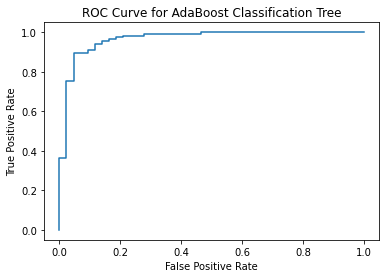

In [19]:
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = AdaBoostClassifier(
        DecisionTreeClassifier(max_leaf_nodes=19), n_estimators=200,algorithm="SAMME")
model.fit(X_train, y_train)
label_encode = preprocessing.LabelEncoder()
#y_val = np.array(y_val)
label =  label_encode.fit(y_val)
y_val = label.transform(y_val)
prediction = model.predict_proba(X_val)
fpr,tpr,thresholds = metrics.roc_curve(y_val, prediction[:, 1], pos_label = 1) #consider male
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for AdaBoost Classification Tree")
print(metrics.auc(fpr, tpr))
plt.savefig("ROC.png")
#TP = (y_val == prediction)
#TP = sum(TP==True)
#TP_FN = sum(y_val==True)
#TP_FN
#plt.plot(true)
metrics.auc(fpr, tpr)

Training using all training set

In [17]:
model = AdaBoostClassifier(
        DecisionTreeClassifier(max_leaf_nodes=19), n_estimators=200,algorithm="SAMME")
model.fit(X, y)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_leaf_nodes=19),
                   n_estimators=200)

#  Feature  importance
1. words spoken by males and females
2. Year of release
3. Money made by film

the validation error of all features is  0.8525641025641025
the validation error of drop year is  0.8525641025641025


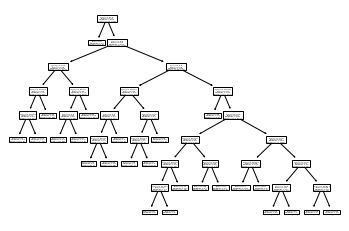

In [49]:
# Including all variable (add words spoken by male)
X = filmtalkTrain.drop(['Lead'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error of all features is ", 1 - misclassification)
# include Number words male and female year
X = filmtalkTrain.drop(['Lead',  'Year'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error of drop year is ",  1-misclassification)
# prediction result becomes better, meaning these variable useful

the validation error is  0.1987179487179487


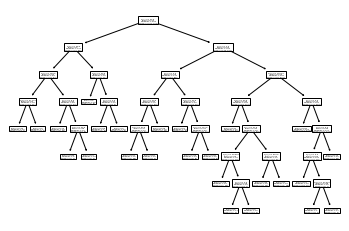

In [26]:
# Omitting these variables
X = filmtalkTrain.drop(['Lead', 'Number words male', 'Number words female',  'Year',  'Gross'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error is ",  1 - misclassification)
# Accuracy decreases when omitting all these three variables

the validation error is  0.8012820512820513


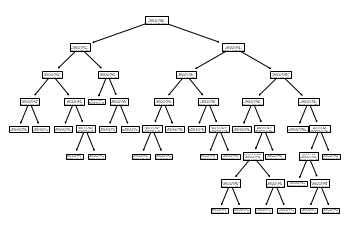

In [34]:
# only include Year
X = filmtalkTrain.drop(['Lead', 'Number words male', 'Number words female', 'Gross'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error is ", 1-  misclassification)
# No changes at all, meaning that year has nothing to do with the prediction

the validation error is  0.8269230769230769


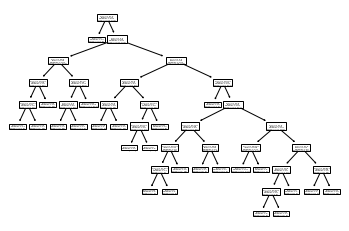

In [24]:
# Only include Number of words female
X = filmtalkTrain.drop(['Lead', 'Number words male', 'Year',  'Gross'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error is ",  1- misclassification)
# the accuracy increases meaning that "number of words female" has something to do with the prediciton

the validation error is  0.7884615384615384


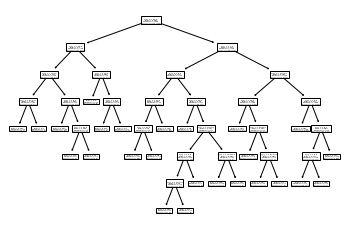

In [23]:
#only include number of words male
X = filmtalkTrain.drop(['Lead', 'Number words female',  'Year',  'Gross'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error is ", 1 - misclassification)
# Only include the "number of words male" actually makes the prediction result even worse than the one that omiting
#  all these three features

the validation error is  0.14743589743589744


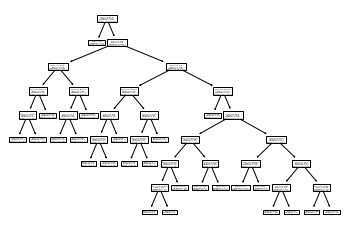

In [28]:
# only include  words female and male
X = filmtalkTrain.drop(['Lead', 'Year',  'Gross'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error is ",  misclassification)
# useful

the validation error is  0.1987179487179487


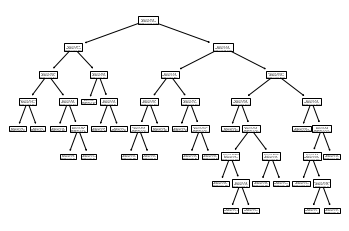

In [19]:
# Only include money made by film
X = filmtalkTrain.drop(['Lead', 'Number words male', 'Number words female',  'Year'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error is ",  misclassification)
# the prediction result doesn't change, meaning money made by film has nothing to do with model prediction.

the validation error is  0.1987179487179487


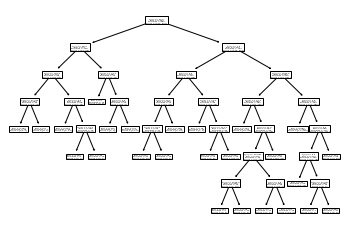

In [34]:
# include money made by film and Year
X = filmtalkTrain.drop(['Lead', 'Number words male', 'Number words female'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error is ",  misclassification)
# the prediction result doesn't change, meaning money made by film and Year has nothing to do with model prediction.

the validation error is  0.8525641025641025


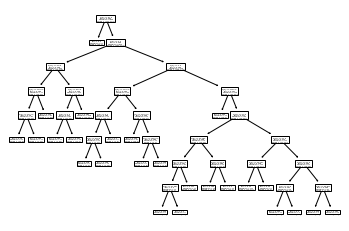

In [43]:
# include Number words male and female, Gross
X = filmtalkTrain.drop(['Lead',   'Year'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=25)
model = model.fit(X_train, y_train)
tree.plot_tree(model)
prediction = model.predict(X_val)
misclassification = np.mean(prediction!=y_val)
print("the validation error is ",  1- misclassification)
# prediction result becomes better, meaning these variable useful

the accuracy is  0.7884615384615384


ValueError: x and y must be the same size

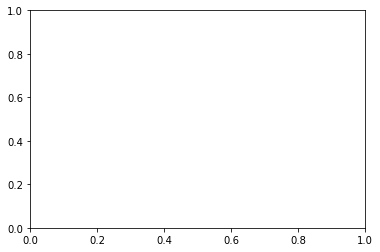

In [63]:
# include Number words male and female, Gross
X = filmtalkTrain.drop(['Lead', 'Year', 'Number words male', 'Number words female'], axis = 'columns')
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
model = tree.DecisionTreeClassifier(max_leaf_nodes=20)
model = model.fit(X_train, y_train)
#tree.plot_tree(model)
prediction = model.predict_proba(X_val)
#misclassification = np.mean(prediction!=y_val)
print("the accuracy is ",  1- misclassification)
plt.scatter(X_val, prediction)
# prediction result becomes better, meaning these variable useful

### Deal with biased Data

In [25]:
from sklearn.utils import resample
X_imbalanced = filmtalkTrain.drop(['Lead'], axis = 'columns')
y_imbalanced = filmtalkTrain['Lead']
X_oversampled, y_oversampled = resample(X_imbalanced[y_imbalanced == 'Female'],
                                        y_imbalanced[y_imbalanced == 'Female'],
                                        replace=True,
                                        n_samples=2*X_imbalanced[y_imbalanced == 'Female'].shape[0],
                                        random_state=123)
#
# Append the oversampled minority class to training data and related labels
#
X_balanced = np.vstack((X_imbalanced[y_imbalanced == 'Male'], X_oversampled))
y_balanced = np.hstack((y_imbalanced[y_imbalanced == 'Male'], y_oversampled))
sum(y_balanced == 'Female')
np.shape(y_balanced)

(1293,)

0.06701030927835051


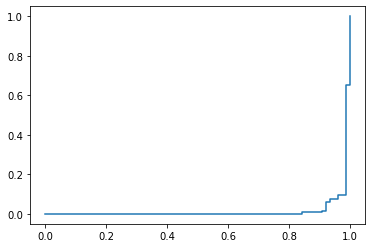

In [23]:
X_train_balanced, X_val_balanced,y_train_balanced, y_val_balanced = train_test_split(X_balanced, y_balanced, test_size=0.15, random_state=42)
model = AdaBoostClassifier(
        DecisionTreeClassifier(max_leaf_nodes=19), n_estimators=200,algorithm="SAMME")
model.fit(X_train_balanced, y_train_balanced)
label_encode = preprocessing.LabelEncoder()
#y_val = np.array(y_val)
label =  label_encode.fit(y_val_balanced)
y_val_balanced = label.transform(y_val_balanced)
prediction_prob = model.predict_proba(X_val_balanced)
fpr,tpr,thresholds = metrics.roc_curve(y_val_balanced, prediction_prob[:, 0], pos_label = 1)
plt.plot(fpr, tpr)
metrics.auc(fpr, tpr)
prediction = model.predict(X_val_balanced)
prediction = label.transform(prediction)
print(np.mean(prediction!=y_val_balanced))

ValueError: s must be a scalar, or float array-like with the same size as x and y

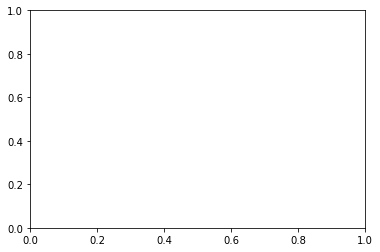

In [60]:
from sklearn.model_selection import train_test_split
X = filmtalkTrain['Gross']
y = filmtalkTrain['Lead']
X_train, X_val,y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train   = [X_train]
X_train  = np.reshape(X_train, (-1, 1))
X_val  = [X_val]
X_val = np.reshape(X_val, (-1, 1))
model = tree.DecisionTreeClassifier(max_leaf_nodes=21)
model = model.fit(X_train, y_train)
prediction = model.predict_proba(X_val)
plt.scatter(X_val, prediction[:, 0])
plt.scatter(X_val, prediction[:,0])
plt.xlabel('Gross')
plt.ylabel('')

In [18]:
!jupyter nbconvert --to script SML_mini-project.ipynb

[NbConvertApp] Converting notebook SML_mini-project.ipynb to script
[NbConvertApp] Writing 15505 bytes to SML_mini-project.py
